In [43]:
!pip install netron

  Using cached netron-8.2.9-py3-none-any.whl.metadata (1.5 kB)
Using cached netron-8.2.9-py3-none-any.whl (1.9 MB)


In [44]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import netron


In [2]:
df_train = pd.read_csv('train_df.csv')
df_test = pd.read_csv('test_df.csv')

train = df_train["value"].values
test = df_test["value"].values

In [3]:
def create_sequences(data, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])  # Sekwencja wejściowa
        y.append(data[i + sequence_length])   # Wartość docelowa
    return np.array(X), np.array(y)

# Przygotowanie danych wejściowych i wyjściowych
sequence_length = 24
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (11707, 24), y_train shape: (11707,)
X_test shape: (2909, 24), y_test shape: (2909,)


In [34]:
# Przygotowanie modelu LSTM
model = Sequential([
    LSTM(48, activation='tanh', return_sequences=True, input_shape=(sequence_length, 1)),  # Pierwsza warstwa LSTM z większą liczbą jednostek
    LSTM(24, activation='tanh', return_sequences=True),  # Druga warstwa LSTM z większą liczbą jednostek
    LSTM(12, activation='tanh'),  # Trzecia warstwa LSTM
    Dense(1)  # Warstwa wyjściowa
])

# Ustawienie dużego learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Kompilacja modelu
model.compile(optimizer=optimizer, loss='mse')

# Wyświetlenie podsumowania modelu
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 48)         │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 24, 24)         │         7,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 12)             │         1,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,397 (71.86 KB)

 Trainable params: 18,397 (71.86 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Trenowanie modelu
# Dodanie metryki MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Trenowanie modelu
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Ocena modelu na danych testowych
loss = model.evaluate(X_test, y_test)
print(f"Loss on test data: {loss}")

# Predykcja na danych testowych
y_pred = model.predict(X_test)

# Obliczenie MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on test data: {mape}%")


Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 351627776.0000 - val_loss: 457260032.0000
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 348300512.0000 - val_loss: 455644544.0000
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 348848864.0000 - val_loss: 454040032.0000
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 345831648.0000 - val_loss: 452443200.0000
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 346403968.0000 - val_loss: 450850976.0000
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 343088032.0000 - val_loss: 449263232.0000
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 342498432.0000 - val_loss: 447678656.0000
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 339545760.0000 - val_loss: 446098976.0000
Epoch 9/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 341961600.0000 - val_loss: 444523264.0000
Epoch 10/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 336332928.0

In [39]:
# model.save('lstm_model.keras')
model = tf.keras.models.load_model('lstm_model.keras')

In [45]:
netron.start("lstm_model.keras")

Serving 'lstm_model.keras' at http://localhost:8080


('localhost', 8080)

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)
# Obliczanie mRSE
mse = mean_squared_error(y_test, y_pred)
mean_y_test = np.mean(y_test)
mRSE = np.sqrt(mse) / mean_y_test

# Obliczanie MAE
MAE = mean_absolute_error(y_test, y_pred)

# Obliczanie MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(y_test, y_pred)

print(f"mRSE: {mRSE}")
print(f"MAE: {MAE}")
print(f"MAPE: {MAPE}%")

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
mRSE: 0.15995885551047756
MAE: 2602.738303406454
MAPE: 14.204219110741075%


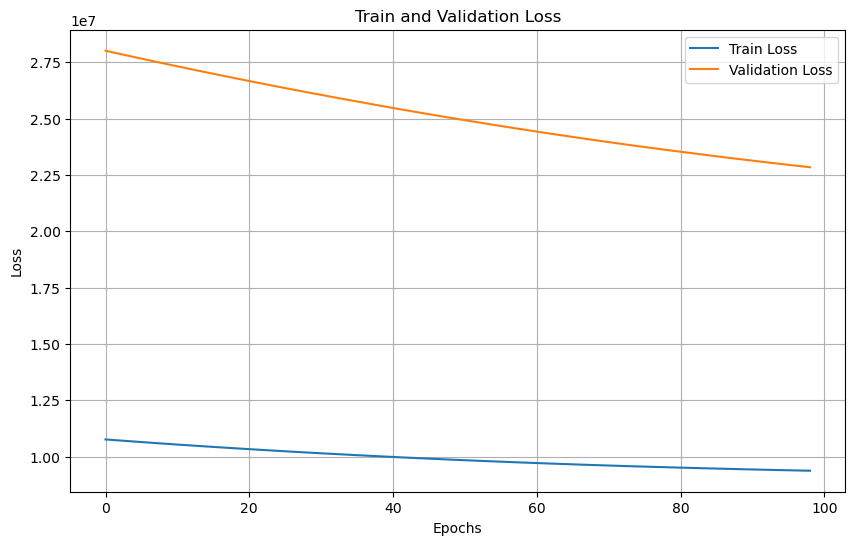

In [25]:
import matplotlib.pyplot as plt

# Wyciągnięcie danych z historii trenowania
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()